In [14]:
import tensorflow as tf
import os 
import numpy as np
import tqdm
from itertools import combinations
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

testdataset_dir="/home/fxf/sdk-update/bin/query_mask_aligned"
txt_save_path = '/home/fxf/TestDataset_generate/glass_mask/glass_mask_pairs.txt'

class_list = next(os.walk(testdataset_dir))[1]
class_list.sort()
class_num=len(class_list)

In [9]:
pair_list=[]
n_num=0
p_num=0
NP_proportion=0.3
for face_class in class_list:
    class_dir=os.path.join(testdataset_dir,face_class)
    face_list=os.listdir(class_dir)
    comb = list(combinations(face_list, 2))
    pair_num=len(comb)
    p_num+=pair_num
    for i in comb:
        pair_list.append((os.path.join(class_dir,i[0]),os.path.join(class_dir,i[1]),1))

In [15]:
print(p_num)
print(pair_list[0])

1436
('/home/fxf/sdk-update/bin/query_mask_aligned/1/1_1.jpg', '/home/fxf/sdk-update/bin/query_mask_aligned/1/1_2.jpg', 1)


In [16]:
n_num=int(p_num*NP_proportion)
print(n_num)
for i in range(n_num):
    member1 = class_list[np.random.randint(0, class_num)]
    member2 = class_list[np.random.randint(0, class_num)]
    if member1 == member2:
        continue
    img1_dir=os.path.join(testdataset_dir, member1)
    img2_dir=os.path.join(testdataset_dir, member2)
    img_1=os.listdir(img1_dir)[0]
    img_2=os.listdir(img2_dir)[0]
    # print(os.path.join(img2_dir,img_2))
    pair_list.append((os.path.join(img1_dir,img_1), os.path.join(img2_dir,img_2), 0))

    # save pairs(list) to a txt 
    with open(txt_save_path, 'w') as f:
        for pair in pair_list:
            f.write("{} {} {}\n".format(pair[0], pair[1], pair[2]))

430


In [17]:
print(pair_list[1435])

('/home/fxf/sdk-update/bin/query_mask_aligned/9/9_4.jpg', '/home/fxf/sdk-update/bin/query_mask_aligned/9/9_1.jpg', 1)


In [18]:
"""
    Part Two:
    生成tfrecord格式的测试文件
"""
TestTFPath = '/home/fxf/TestDataset_generate/glass_mask/glass_mask_pairs.tfrecord'

def build_example(image1, image2, label):
    example = tf.train.Example(features=tf.train.Features(feature={
        'image1': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image1])),
        'image2': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image2])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }))
    return example

# read pairs(list) from the txt 
with open(txt_save_path, 'r') as f:
    data = f.readlines()
    
writer = tf.io.TFRecordWriter(TestTFPath)
for pair in tqdm.tqdm(data):
    img1_path, img2_path, label = pair.split(' ')
    label = int(label[0])
    image1 = open(img1_path, 'rb').read()
    image2 = open(img2_path, 'rb').read()
    tf_example = build_example(image1, image2, label)
    writer.write(tf_example.SerializeToString())
writer.close()

100%|██████████| 1860/1860 [00:00<00:00, 3631.99it/s]


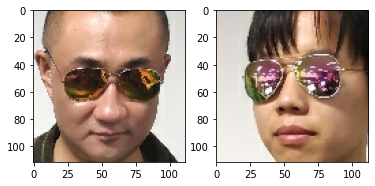

两张照片不是同一个人


In [20]:
# pair 数据展示
    # 加载
img1_path, img2_path, label = data[1500].split(' ')
label = int(label[0])
image1 = open(img1_path, 'rb').read()
image2 = open(img2_path, 'rb').read()
    # 转换
img1 = tf.image.decode_jpeg(image1, channels=3)
img2 = tf.image.decode_jpeg(image2, channels=3)
    # 显示
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()
if label:
    print("两张照片是同一个人")
else:
    print("两张照片不是同一个人")

In [21]:
"""
    Part Three:
    
"""
TestTFPath = '/home/fxf/TestDataset_generate/glass_mask/glass_mask_pairs.tfrecord'
batch_size = 8
input_shape = 112

IMAGE_FEATURE_MAP = {
    'image1': tf.io.FixedLenFeature([], tf.string),
    'image2': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

def parse_tfrecord(single_record, input_shape):
    x = tf.io.parse_single_example(single_record, IMAGE_FEATURE_MAP)

    image1 = tf.image.decode_jpeg(x['image1'], channels=3)
    image1 = tf.image.resize(image1, (input_shape, input_shape))
    image1 = image1/255
    image2 = tf.image.decode_jpeg(x['image2'], channels=3)
    image2 = tf.image.resize(image2, (input_shape, input_shape))
    image2 = image2/255
    label = tf.stack([tf.cast(x['label'], 'int32')])
    return image1, image2, label

def load_tfrecord_dataset(file_pattern, input_shape):
    files = tf.data.Dataset.list_files(file_pattern)
    dataset = files.flat_map(tf.data.TFRecordDataset)
    return dataset.map(lambda x: parse_tfrecord(x, input_shape))


train_dataset = load_tfrecord_dataset(TestTFPath, input_shape)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=-1)

In [22]:
model = tf.keras.models.load_model('/home/fxf/resnet50_pre-training/saved_resnet50_model')
print("load model successfully!")

distances = []
labels = []
for image1, image2, label in tqdm.tqdm(train_dataset):
    feature1 = model(image1)
    feature2 = model(image2)
    # feature1 = tf.math.l2_normalize(feature1, 1)
    # feature2 = tf.math.l2_normalize(feature2, 1)
    distance = tf.math.reduce_sum((feature1-feature2)**2, axis=1)
    for x in distance.numpy():
        distances.append(x)
    for x in label.numpy():
        labels.append(x[0])

distances = np.array(distances)
labels = np.array(labels)

load model successfully!


0it [00:00, ?it/s]2022-09-18 18:49:08.899988: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-18 18:49:08.920287: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000020000 Hz
2022-09-18 18:49:09.009774: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-09-18 18:49:12.094413: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-09-18 18:49:12.646757: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
233it [00:46,  5.06it/s]


In [23]:
threshold_nums = 1000
dists_len = len(distances)

th_base = np.min(distances)
th_step = (np.max(distances)-th_base)/threshold_nums
threshold_list = np.array([th_base+th_step*i for i in range(threshold_nums)])
acc_list = []
for th in tqdm.tqdm(threshold_list):
    acc_count = 0
    for i, x in enumerate(distances):
        acc_count += int((x <= th) == labels[i])
    acc = acc_count/dists_len
    acc_list.append(acc)
acc_list = np.array(acc_list)
max_index = np.argmax(acc_list)
max_accu = acc_list[max_index]
th = th_base+max_index*th_step

100%|██████████| 1000/1000 [00:25<00:00, 39.32it/s]


In [24]:
print(max_accu, th)

0.8333333333333334 144217.94744140626
